# STAT 628 Module 1 Group 4 Jupyter Notebook

Group members: **Chen, Yixin ; Li, Jiatong ; Qiang, Shuo**

## Introduction & Background

Body fat percentage, a measure of obesity, plays an important role in various health outcomes such as life expectancy, the prognosis for disease, healthcare costs, and the general well-being of individuals. 
This project is to design a simple and robust rule-of-thumb calculator for the percentage of body fat. 

The original dataset contains 252 rows and 17 columns. Within the 17 columns, the first one is the index, the second one is the response variable BODYFAT, the third one is DENSITY, and the 14 columns left are our potential covariates. 

We propose our AAW model: $BODYFAT (\%) = 0.073*AGE(years) + 0.72*ABDOMEN(cm) - 2.8*WRIST(cm)$. It is simple, robust, accurate and efficient. The process of how we constructed our AAW model is shown below in this jupyter notebook.

# 1. Data pre-processing

In [11]:
BodyFat<-read.csv("BodyFat.csv",header = T); # dim(BodyFat)  252 17

We printed the summary statistic of all the variables in the data and plotted the histogram plots of all variables.
Below is what we noticed through the summary:
1. In BodyFat, there is a 0 as the min value. (point 182)
2. In Age, there is an old man aged 81. (point 79)
3. In Weight, there is a super fat man weighted 363.1 lbs. (point 39)
4. In Height, there is a man whose height is only 29.5 inches. (point 42)

As mentioned in the data description, there is a formula between Body Fat and Body Density, which is: $Fat(i.e. 100*B) = 495/D - 450$, where B stands for the BodyFat and D stands for Density in our data. With this formula, we generated an imputed bodyfat. We ranked it by the absolute variance from the largest to the smallest and found that no.96 is the only one that BODYFAT and DENSITY don't obey the formula.

Similarly, since we have the BMI value named ADIPOSITY in the data, we can check whether there exist inaccurate data points. Considered the scale of HEIGHT, WEIGHT and ADIPOSITY, the formula should be: $ Adiposity (kg/m^2) =  Weight (lbs) * 0.454 / ( Height (inches) * 0.0254 ) ^ 2 $. Using the same method, we noticed that no. 96 has a big difference between BodyFat and Density, which means that at least one in BodyFay and Density of this person is wrong. Even though there are other points (no.48, no.76) that we can see difference between BodyFat and Density, the difference is not as large as individual no. 96. Besides, point no.42 does not obey the formula of BMI.

From the analysis above, we planed to check these points one by one: 182,79,39,42,96

In [12]:
BodyFat[c(182,79,39,42,96),-1]

,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
182,0.0,1.1089,40,118.50,68.00,18.1,33.8,79.3,69.4,85.0,47.2,33.5,20.2,27.7,24.6,16.5
79,21.1,1.0498,81,161.25,70.25,23.0,37.8,96.4,95.4,99.3,53.5,37.5,21.5,31.4,26.8,18.3
39,33.8,1.0202,46,363.15,72.25,48.9,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
42,31.7,1.0250,44,205.00,29.50,29.9,36.6,106.0,104.3,115.5,70.6,42.5,23.7,33.6,28.7,17.4
96,17.3,1.0991,53,224.50,77.75,26.1,41.1,113.2,99.2,107.5,61.7,42.3,23.2,32.9,30.8,20.4


1. For point no.182, the imputed body fat from density is -3.6, which is below zero. A person cannot have zero bodyfat, and especially the imputed value is even negative, thus we decided to delete this point.
2. For point no.42, this is a person whose height is only 29.5 inches. We noticed that all his values except for HEIGHT are normal. We tended to use the height calculated by the BMI formula(69.428 inches) to replace the original value(29.5 inches).
3. For the other points, we cannot find significant errors. Therefore, we would analyze in the next section.

Aftering the points with inaccurate data and do linear regression using all the features. From the plot of the model, we could get that all the points are fine here and no. 39 is the most influential point. No. 39 should be a leverage point with some large values. We deleted it since it is an extreme point and can't show the relations among the ordinary people. And no. 96 is a normal point here, so we used the DENSITY value calculate by BODYFAT for this point.

In [13]:
BodyFat$DENSITY[96] <- 495/(BodyFat$BODYFAT[96] + 450)
BodyFat$HEIGHT[42] <- 69.428
y <- BodyFat[-c(39, 182), 2]; x <- BodyFat[-c(39, 182), 4:17]

## 2. Statistical Modeling

To get a simple and robust model, we only consider linear model and try to find the best one here. Thus, feature selection is most important.

### 1) Normal linear models

In this section, we use the original features to do linear regression and feature selection. There are three main search algorithms: the exhaustive search, the random search and the sequential search. The exhaustive search is computationally expensive, so we didn't use it. First, we used the stepwise method to select features. We chose BIC as criterions and directions of both.

In [15]:
m1 <- lm(y~., data = x)
#step(m1, direction = "both" , criterion = "bic")

Through the stepwise method, we got 8 features here: AGE, ADIPOSITY, NECK, CHEST, ABDOMEN, HIP, FOREARM and WRIST. Then, we used the random method to sort the features. We chose features randomly at each time by setting the maximum number of features. To evaluate the performance of this subset, we use bootstrap to replay the regression procedure a large number of times and get the total mean squared error as the criterion. [1]

Let $y_{ij}$ represent the $j^{th}$ sample in $i^{th}$ bootstrap and $\hat{y_{ij}}$ represents the estimator of $y_{ij}$. 
$score =\frac{ \Sigma_i \Sigma_j (\hat{y_{ij}}-y_{ij})^2}{\#\ of\ y_{ij}}$

Then, for each feature, we calculated the mean score from subsets which contain this feature. The most important feature has the smallest mean score. 

In [16]:
source("bootstrap.R") #This is a function to get a bootstrap list.
source("sort_feature.R") # This is a function to sort features by importance.
source("cal_score.R") #This is a function to calculate the score of models using mean square error.

In [20]:
print(sort_feature(y,x))
print(round(cal_score(y , x[,c("ABDOMEN" , "AGE" , "CHEST" , "ADIPOSITY" , "WRIST")] , intercept = F), 2))

  ABDOMEN ADIPOSITY       AGE    HEIGHT     WRIST     CHEST    WEIGHT       HIP 
 17.37825  21.49221  21.60407  21.93425  21.94892  22.00026  22.01797  22.11106 
     NECK     THIGH      KNEE     ANKLE   FOREARM    BICEPS 
 22.24423  22.33441  22.34730  22.43147  22.44330  22.50881 
[1] 15.19


We got a list of sorted features and found that top 8 features are similar to the features we selected from the previous method. But the model with 8 features are too complicated and there are some features are nonsignificant. Now we consider how to simplify the model while the model doesn't lose too much accuracy. By deleting the nonsignificant features, we first got a model with five variables, which are ABDOMEN, AGE, CHEST, ADIPOSITY and WRIST. The mean score is 15.19, which is very good. Besides, from the summary of the model, the five parameters are all significant. However, we considered it a bit complicated, and therefore we wanted to find the simpler model with fewer variables. And here we got our best model below:

In [17]:
print(round(cal_score(y , x[,c("ABDOMEN" , "AGE" , "WRIST")] , intercept = F), 2))
print(round(summary(lm(y~ABDOMEN+AGE+WRIST+0, data = x))$r.squared,4))
summary(lm(y~ABDOMEN+AGE+WRIST+0, data = x))$coefficients

[1] 15.97
[1] 0.9617


,Estimate,Std. Error,t value,Pr(>|t|)
ABDOMEN,0.72355664,0.03103519,23.314068,2.453548e-64
AGE,0.07261292,0.02084394,3.483646,5.849681e-04
WRIST,-2.80716125,0.15888072,-17.668356,1.015516e-45


1. We only have three features here and we can see that the p-values are all small enough, which means the parameters are all significant. 
2. The mean score is 15.97, which means the model doesn't lose too much accuracy. 
3. Besides, we can get a R-squared value as large as 0.9617, which is also good enough. 

### 2) Linear models with generating features

It's obvious that someone who is higher will have the other values like abdomen larger. So we consider generating new data using original feature divided by height expect age and adiposity. [2] Repeating the procedure above, we get the best model below:

In [18]:
newx <- x[,c(2,5:14)]/x$HEIGHT
newx$ADIPOSITY <- x$ADIPOSITY; newx$AGE <- x$AGE
print(round(cal_score(y , newx[,c("ABDOMEN" , "WRIST")]), 2))
summary(lm(y~., data = newx[,c("ABDOMEN" , "WRIST")]))$coefficient

[1] 15.69


,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),-15.74431,5.210583,-3.021603,2.778782e-03
ABDOMEN,50.31442,2.145835,23.447481,9.277489e-65
WRIST,-121.39672,24.391491,-4.977011,1.211750e-06


**Result**: Until now, we get two models whose mean scores don't have too much difference. But the precision of the first model is better than the second one. We choose the first one as our final result.

## 3. Model Diagnosis & Strength and Weakness

**Final Model**: According to the analysis above, we chose our best model which contains AGE, ABEDOMEN and WRIST. We named it AAW model: $$BODYFAT (\%) = 0.073*AGE(years) + 0.72*ABDOMEN(cm) - 2.8*WRIST(cm)$$
**Interpretation**: A person may have larger body fat percentage with larger age and abdomen. And the value of the wrist term try to slow down the increase of abdomen term.

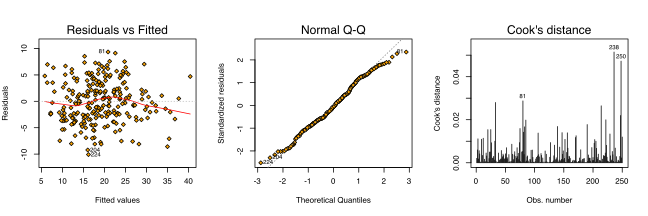

In [22]:
lm_AAW <- lm(y~ABDOMEN+AGE+WRIST+0, data = x)
options(jupyter.plot_mimetypes = 'image/svg+xml')
options(repr.plot.width=9,repr.plot.height=3)
par(mfrow=c(1,3))
plot(lm_AAW,pch=23,bg="orange",cex=0.9,  which = c(1,2,4))

**Strength and Weakness of our model**: 
Generally, this AAW model is a simple, robust, accurate and efficient model, although it also has weaknesses as it cannot capture higher order effects and interactions.
1. Linearity: Residual plot doesn't have a significant pattern.
2. Homoscedasticity: Satisfied by looking at the residual plot.
3. Normality: Normality assumption holds through the QQ plot.
4. Accuracy: The precision of our body fat (\%) prediction is good and it explains 96.2\% of the variation in body fat \% among men.

**Conclusions**: 
Overall, our model provides an easy-to-remember way of estimating the bodyfat % purely based on ABDOMEN, AGE and WRIST. Though it contains three variables, the formula doesn't contain an intercept. AGE is something everyone can remember, and it's easy to measure the ABDOMEN and WRIST using one single tape measure. Moreover, this model is also very precise since it beat many other models on precision.

## Commitments

1. Jiatong detected the inaccurate records and outliers in the original data. She applied stepwise AIC/BIC for feature selection and built simple linear models. She analyzed the strength and weakness of the final model. What's more, she is responsible for the presentation slides, codes and image files of the data pre-processing and diagnosis parts. 
2. Yixin applied the bootstrap method for feature selection. Besides the original features, she also tried some generated features and built models. She compared the performances of different models and found the best model. In addition, she is responsible for the presentation slides, codes and image files of the modelling part.
3. Shuo did data cleaning and feature selection using the Tree Model. He analyzed the diagnosis plots of the final model. Moreover, he was mainly responsible for constructing the Github interface and the Shiny Application. Plus, he is responsible for the presentation slides, codes and image files of the Shiny part.

## References

1. Diaz-Diaz, N., Aguilar-Ruiz, J., Nepomuceno, J., & Garcia, J. (n.d.). Feature selection based on bootstrapping. 2005 ICSC Congress on Computational Intelligence Methods and Applications. doi:10.1109/cima.2005.1662338
2. 6 Ways to Measure Body Fat Percentage. https://www.healthline.com/health/how-to-measure-body-fat#takeaway